## Preamble


* A model of lumpy investment wherein firms face persistent shocks to common and plant-specific productivity, and nonconvex adjustment costs.

* The model extends the real business cycle model to include firm heterogeneity and fixed capital adjustment costs. The aggregate state vector of the model contains the distribution of firms over idiosyncratic productivity and capital, which evolves over time in response to aggregate productivity shocks.

* The dynamics of the distribution must satisfy a complicated fixed point problem: each firm’s investment decision depends on its expectations of the dynamics of the distribution, and the dynamics of the distribution depend on firms’ investment decisions.

* **This infinite-dimensional fixed point problem is at the heart of the computational challenges faced by the heterogeneous agent literature.**

In [1]:
# Find toolbox analogue in HARK 
# Analogue of tauchen for HARK
%matplotlib notebook
import numpy as np
from quantecon.markov.approximation import tauchen
import scipy.optimize as opt
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import quantecon
import scipy.interpolate as intpl
from matplotlib import cm
from numba import vectorize, jit, njit, float64, prange

## Associated Literature

* Host of Papers that look at the heterogeneity through the firm channel.


   * Micro-level Heterogeneity and Transmission: [Reiter, Sveen and Weinke (2013)] **(_Lumpy investment and the monetary transmission mechanism_)**, [Koby and Wolf (2019)] **(_Investment Stimulus: From Micro Elasticities to Macro Counterfactuals_)**.
   
   * Financial heterogeneity and  the business cycle dynamics of aggregate investment: [Khan, Senga and Thomas (2016)] **(_Default Risk and Aggregate Fluctuations in an Economy with Production Heterogeneity_)**.

   * Investment and Business Cycle: [Cooper, Haltiwanger (2006)] **(_Machine Replacement and the Business Cycle: Lumps and Bumps_)**. 
   
   * Heterogeneity and computation: [Krusell, Smith (1998)] **(_Income and wealth heterogeneity in the macroeconomy_)**.

Now we will solve for the mass of entrants \( m^{*} \) and the stationary measure of incumbent firms \( g^{*}(\varepsilon, k) . \) As discussed by Hopenhayn and Rogerson \( (1993), \) the stationary measure is linearly homogenous in the amount of entry \( m^{*} . \) That is, if we double the amount of entrants
\( m^{*}, \) then we will double the total mass of firms in the economy but the fraction of firms with any particular pair \( (\varepsilon, k) \) is constant. Therefore, we proceed in two steps: first, solve for the stationary measure with \( m^{*}=1 ; \) and second, solve for the mass of entrants \( m^{*} \) itself.


(a) Step 1: We solve for stationary measure with \( m^{*}=1 \) In principle, the stationary distribution must satisfy the law of motion \[ g^{*}\left(\varepsilon^{\prime}, k^{\prime}\right)=\int X(\varepsilon, k) \operatorname{Pr}\left(\varepsilon^{\prime} | \varepsilon\right) \mathbb{I}\left\{k^{\prime}(\varepsilon, k)=k^{\prime}\right\} d g^{*}(\varepsilon, k)+m^{*} \operatorname{Pr}\left(\nu=\varepsilon^{\prime}\right) \] where \( X(\varepsilon, k) \) is an indicator variable for whether a firm \( (\varepsilon, k) \) will survive (i.e., choose not to exit the economy). 
To go about this, we iterate, on a numerical approximation of this equation with \( m^{*}=1 . \) In order to do so, assume that the capital stock \( k \) takes values in a discrete grid \( \mathbf{k}=\left(k_{1}, \ldots, k_{N}\right) \) where \( k_{i}>k_{i-1} \) and \( n_{k} \) is the total number of grid points. Under this assumption, the measure \( g(\varepsilon, k) \) can be represented by a \( n_{\varepsilon} \times n_{k} \) matrix or, in more compact form, a \( n_{\varepsilon} n_{k} \times 1 \) vector. 

We iterate on 
\( g\left(\varepsilon_{k}, k_{l}\right)=\sum_{i=1}^{n_{e}} \sum_{j=1}^{N} \operatorname{Pr}\left(\varepsilon^{\prime}=\varepsilon_{k} | \varepsilon=\varepsilon_{i}\right) \|\left\{k_{i j}^{\prime} \in k_{l}\right\} X\left(\varepsilon_{i}, k_{j}\right) g\left(\varepsilon_{i}, k_{j}\right)+m^{*} \operatorname{Pr}\left(\nu(\varepsilon)=\varepsilon_{k}\right) \)​
​
where the notation \( \mathbb{N}\left\{k_{i j}^{\prime} \in k_{l}\right\} \) means that \( k_{l} \) is the closest gridpoint to \( k^{\prime}\left(\varepsilon_{i}, k_{j}\right) . \)

* First, Microeconomic lumpiness continues to have perceptible effects on aggregate investment dynamics only when equilibrium factor supply considerations are ignored.
   * General equilibrium itself matters tremendously in shaping aggregate dynamics. 
      
      * First, it is extremely effective in smoothing changes in aggregate series, yielding investment rates close to the postwar U.S. data in both their cyclical variability and persistence, irrespective of capital adjustment costs. 
      * Second, it dampens much of the movement along the extensive margin that would otherwise distinguish the lumpy investment economy, leaving no trace of aggregate nonlinearities.

* Second, they find that the near-zero skewness and excess kurtosis in their general equilibrium models’ aggregate investment rate series matches the third and fourth moments of postwar U.S. aggregate investment rates reasonably well, and far more closely than does the partial equilibrium lumpy model.

* Third, they find that the microeconomic role of nonconvex capital adjustment costs can change substantially in the presence of persistent idiosyncratic risk. When plant-specific productivity shocks are volatile relative to aggregate shocks, as suggested by the data, nonconvex costs no longer cause the plant-level investment spikes that are the hallmark of lumpy investment.


# Model (Winberry version of KT)

I adopt the Winberry adaptation (2018) of KT. It is useful for computation and is a little bit more tractable. This is the standard Benchmark RBC model with firm heterogeneity.

* **Firms**


There is a fixed mass of firms j $\in$ [0, 1] which produce output $y_{t}$ according to the
production function

$$
y_{j t}=e^{z_{t}} e^{\varepsilon_{j t}} k_{j t}^{\theta} n_{j t}^{\nu},  \theta+\nu<1
$$

where \( z_{t} \) is an aggregate productivity shock, \( \varepsilon_{j t} \) is an idiosyncratic productivity shock, \( k_{j t} \) is capital, \( n_{j t} \) is labor, \( \theta \) is the elasticity of output with respect to capital, and \( \nu \) is the elasticity of output with respect to labor. The aggregate shock \( z_{t} \) is common to all firms and follows the AR ( 1) process 
\[ z_{t+1}=\rho_{z} z_{t}+\sigma_{z} \omega_{t+1}^{z}, \text { where } \omega_{t+1}^{z} \sim N(0,1) \]

The idiosyncratic shock \( \varepsilon_{j t} \) independently distributed across firms, but within firms follows the AR ( 1) process
\[ \varepsilon_{j t+1}=\rho_{\varepsilon} \varepsilon_{j t}+\sigma_{\varepsilon} \omega_{t+1}^{\varepsilon}, \text { where } \omega_{t+1}^{\varepsilon} \sim N(0,1) \]

In each period, the firm \( j \) inherits its capital stock from previous periods' investments, observes the two productivity shocks, hires labor from a competitive labor market, and produces output.

After production, the firm invests in capital for the next period. Gross investment \( i_{j t} \) yields \( k_{j t+1}=(1-\delta) k_{j t}+i_{j t} \) units of capital next period, where \( \delta \) is the depreciation rate of capital. If \( \frac{i_{t}}{k_{j t}} \notin[-a, a], \) the firm must pay a fixed adjustment cost \( \xi_{j t} \) in units of labor. The parameter \( a \) governs a region around zero investment within firms do not incur the fixed cost. The fixed cost \( \xi_{j t} \) is a random variable distributed uniformly \( [0, ], \)  and independently over firms and time.

* **Households**

The function \[ \mathbb{E} \sum_{t=0}^{\infty} \beta^{t}\left[\frac{C_{t}^{1-\sigma}-1}{1-\sigma}-\chi \frac{N_{t}^{1+\alpha}}{1+\alpha}\right] \] where \( C_{t} \) is consumption, \( N_{t} \) is labor supplied to the market, \( \beta \) is the discount factor, \( \sigma \) is the coefficient of relative risk aversion, \( \chi \) governs the disutility of labor supply, and \( 1 / \alpha \) is the Frisch elasticity of labor supply. The total time endowment per period is normalized to 1, so that \( N_{t} \in[0,1] \). The household owns all the firms in the economy and markets are complete.




## Solving the Model

The household optimization is loaded into the firm's optimization problem by approximating the transformed value as is done in Khan and Thomas (2008),

\begin{equation}
\begin{aligned} 
v(\varepsilon, k, \xi ; \mathbf{s}) &=\lambda(\mathbf{s}) \max _{n}\left\{e^{z} e^{\varepsilon} k^{\theta} n^{\nu}-w(\mathbf{s}) n\right\} \\ &+\max \left\{v^{a}(\varepsilon, k ; \mathbf{s})-\xi \lambda(\mathbf{s}) w(\mathbf{s}), v^{n}(\varepsilon, k ; \mathbf{s})\right\} 
\end{aligned}
\end{equation}

where \( \mathrm{s} \) is the aggregate state vector (defined below), \( \lambda(\mathrm{s})=C(\mathrm{s})^{-\sigma} \) is the marginal of consumption in equilibrium,
\[ v^{a}(\varepsilon, k ; \mathrm{s})=\max _{k^{\prime} \in \mathbb{R}}-\lambda(\mathrm{s})\left(k^{\prime}-(1-\delta) k\right)+\beta \mathbb{E}\left[\widehat{v}\left(\varepsilon^{\prime}, k^{\prime} ; \mathrm{s}^{\prime}\left(z^{\prime} ; \mathrm{s}\right) | \varepsilon, k ; \mathrm{s}\right]\right. \] 

\( v^{n}(\varepsilon, k ; \mathbf{s})=\max _{k^{\prime} \in[(1-\delta-a) k,(1-\delta+a) k]}-\lambda(\mathbf{s})\left(k^{\prime}-(1-\delta) k\right)+\beta \mathbb{E}\left[\widehat{v}\left(\varepsilon^{\prime}, k^{\prime} ; \mathbf{s}^{\prime}\left(z^{\prime} ; \mathbf{s}\right) | \varepsilon, k ; \mathbf{s}\right]\right. \)


and \( \widehat{v}(\varepsilon, k ; \mathbf{s})=\mathbb{E}_{\xi} v(\varepsilon, k, \xi ; \mathbf{s}) \). Denote the unconstrained capital choice from ( 2) by \( k^{a}(\varepsilon, k ; \mathbf{s}) \) and the constrained choice from ( 3) by \( k^{n}(\varepsilon, k ; \mathbf{s}) . \) The firm will choose to pay the fixed cost if and only if \( v^{a}(\varepsilon, k ; \mathbf{s})-\xi \lambda(\mathbf{s}) w(\mathbf{s}) \geq v^{n}(\varepsilon, k ; \mathbf{s}) . \) Hence, there is a unique threshold value of the fixed cost \( \xi \) which makes the firm indifferent between these two options, \[ \tilde{\xi}(\varepsilon, k ; \mathbf{s})=\frac{v^{a}(\varepsilon, k ; \mathbf{s})-v^{n}(\varepsilon, k ; \mathbf{s})}{\lambda(\mathbf{s}) w(\mathbf{s})} \]

Denote \( \widehat{\xi}(\varepsilon, k ; \mathbf{s}) \) as the threshold bounded to be within the support of \( \xi, \) i.e., \( \widehat{\xi}(\varepsilon, k ; \mathbf{s})= \) \( \min \{\max \{0, \widetilde{\xi}(\varepsilon, k ; \mathbf{s})\}, \bar{\xi}\}\} \) It will be numerically convenient to approximate the ex-ante value function \( \widehat{v}(\varepsilon, k ; \mathbf{s})= \) \( \mathbb{E}_{\xi} v(\varepsilon, k, \xi ; \mathbf{s}) \). Given that the extensive margin decision is characterized by the cutoff ( 4) and the fixed cost \( \xi \) is uniformly distributed, the expectation can be computed analytically as

\( \widehat{v}(\varepsilon, k ; \mathbf{s})=\lambda(\mathbf{s}) \max _{n}\left\{e^{z} e^{\varepsilon} k^{\theta} n^{\nu}-w(\mathbf{s}) n\right\} \)
\[ \quad+\frac{\hat{\xi}(\varepsilon, k ; \mathbf{s})}{\xi}\left(v^{a}(\varepsilon, k ; \mathbf{s})-\lambda(\mathbf{s}) w(\mathbf{s}) \frac{\widehat{\xi}(\varepsilon, k ; \mathbf{s})}{\bar{\xi}}\right) v^{n}(\varepsilon, k ; \mathbf{s}) \]


* Recursive Competitive Equilibrium

In the recursive competitive equilibrium, the aggregate state s contains the current draw of the aggregate productivity shock, \( z, \) and the density of firms over \( (\varepsilon, k) \) -space, \( g(\varepsilon, k) . \)

A recursive competitive equilibrium for this model is a set \( \widehat{v}(\varepsilon, k ; \mathbf{s}), \) \( n(\varepsilon, k ; \mathbf{s}), k^{a}(\varepsilon, k ; \mathbf{s}), k^{n}(\varepsilon, k ; \mathbf{s}), \widehat{\xi}(\varepsilon, k ; \mathbf{s}), \lambda(\mathbf{s}), w(\mathbf{s}), \) and \( \mathbf{s}^{\prime}\left(z^{\prime} ; \mathbf{s}\right)=\left(z^{\prime} ; g^{\prime}(z, g)\right) \) such that

1) (Firm optimization) Taking \( w(\mathbf{s}), \lambda(\mathbf{s}), \lambda(\mathbf{s}), \) and \( \mathbf{s}^{\prime}\left(z^{\prime} ; \mathbf{s}\right) \) as given, \( \widehat{v}(\varepsilon, k ; \mathbf{s}), n(\varepsilon, k ; \mathbf{s}) \) \( \quad k^{a}(\varepsilon, k ; \mathbf{s}), k^{n}(\varepsilon, k ; \mathbf{s}), \) and \( \hat{\xi}(\varepsilon, k ; \mathbf{s}) \) solve the firm's optimization problem.

2) (Household Optimization) \(\lambda(\mathbf{s})=C(\mathbf{s})^{-\sigma}, \) where \( C(\mathbf{s})=\int\left[e^{z} e^{\varepsilon} k^{\theta} n(\varepsilon, k ; \mathbf{s})^{\nu}+(1-\delta) k-\left(\frac{\widehat{\xi}(\varepsilon, k ; \mathbf{s})}{\xi}\right) k^{a}(\varepsilon, k ; \mathbf{s})\right. \) \( \left.-\left(1-\frac{\hat{\xi}(\varepsilon, k ; \mathbf{s})}{\xi}\right) k^{n}(\varepsilon, k ; \mathbf{s})\right] g(\varepsilon, k) d \varepsilon d k \) \(w(\mathbf{s}) \) satisfies \( \int\left(n(\varepsilon, k ; \mathbf{s})+\frac{\hat{\xi}(\varepsilon, k ; \mathbf{s})^{2}}{2 \xi}\right) g(\varepsilon, k) d \varepsilon d k=\left(\frac{w(\mathbf{s}) \lambda(\mathbf{s})}{x}\right)^{\frac{1}{\alpha}} \)

3) (Law of motion for distribution) For all \( \left(\varepsilon^{\prime}, k^{\prime}\right) \) \( g^{\prime}\left(\varepsilon^{\prime}, k^{\prime} ; z, \mathbf{m}\right)=\iiint_{ } 1\left\{\rho_{\varepsilon} \varepsilon+\sigma_{\varepsilon} \omega_{\varepsilon}^{\prime}=\varepsilon^{\prime}\right\} \times\left[\frac{\hat{\xi}(\varepsilon, k ; z, \mathbf{m})}{\xi} 1\left\{k^{a}(\varepsilon, k ; z, \mathbf{m})=k^{\prime}\right\}\right] \)
\( \left.g^{\prime}\left(\varepsilon^{\prime}, k^{\prime} ; z, \mathbf{m}\right)=\iiint_{^{-}}^{T}\left(1-\frac{\hat{\varepsilon}(\varepsilon, k ; \mathbf{m})}{\xi}\right) 1\left\{k^{n}(\varepsilon, k ; z, \mathbf{m})=k^{\prime}\right\}\right] \)
\( \times p\left(\omega_{\varepsilon}^{\prime}\right) g(\varepsilon, k ; \mathbf{m}) d \omega_{\varepsilon}^{\prime} d \varepsilon d k \) where \( p \) is the pdf. of idiosyncratic productivity shocks.

4) (Law of motion for aggregate shocks) \( z^{\prime}=\rho_{z} z+\sigma_{z} \omega_{z}^{\prime}, \) where \( \omega_{z}^{\prime} \sim N(0,1) \)

## Parametrization

% Center the Table


| Parameter | Description | Value |
| --- | --- | --- |
| $\beta$ | Discount Factor | .961 |
| $\sigma$ | Utility curvature | 1 |
| $\alpha$ | Inverse Frisch | lim $\alpha \rightarrow$ 0 |
| $\chi$ | Labor Disutility | N*$=\frac{1}{3}$ |
| $\nu$ | Labor Share | 0.64 |
| $\theta$ | Capital Share | 0.256|
| $\delta$ | Capital Depreciation | 0.085 |
| $\rho_{z}$ | Aggregate TFP AR(1) |  0.859 |
| $\sigma_{z}$ | Aggregate TFP AR(1) |  0.014 |
| $a$ | No fixed cost region | 0.011 |
| $\rho_{e}$ | Idiosyncratic TFP AR(1) | 0.859 |
| $\sigma_{e}$ | Idiosyncratic TFP AR(1) | 0.022 |
| $\bar{\xi}$ | Fixed Cost | 0.0083 |
    

## Computational Method 

A code readme is placed in github (to-do) to detail the method. I outline the steps briefly here.

There are three steps involved here. 
* **Step 1**


Approximate the model’s equilibrium objects –  the value function and distribution – using finitedimensional global approximations with respect to individual state variables. This step yields
a finite-dimensional representation of the equilibrium at every point in time. 

* **Step 2**


Compute the stationary equilibrium of the finite-dimensional model in which there are no aggregate shocks but still idiosyncratic shocks. 

* **Step 3**


The final step is to compute the aggregate dynamics of the finite-dimensional model using a locally accurate
Taylor expansion around the stationary equilibrium.


Numerous approximation types are employed such as quadrature methods, spline approximations to move ahead with solving the model.

I try a simpler model of here and progressively will add features to it.

In [20]:
#Parameter dictionary (I start with fixed labor supply in steady state)
KTEconomyDictionary = {
                       "theta" : 0.21,
                       "mu" : 0.64,
                       "delta" : 0.1, 
                       "beta" : 0.96, 
                       "varphi" : 0.5, 
                       "rho" : 0.9, 
                       "sigma" : 0.02, 
                       "n_ss" : 0.6 
}

In [21]:
# Steady State Block
def get_ss(KTEconomyDictionary):
    
    r = (1 / beta) - (1 - delta)
    n = n_ss
    eps = 0
    k = (r / ((n ** mu) * theta * np.exp(eps))) ** (1 / (theta - 1))
    y = np.exp(eps) * (k ** theta) * (n ** mu)
    i = delta * k
    c = y - i
    w = mu * y / n
    a = w / c
    
    return k, w, c, a, i, y

In [22]:
k_ss, w_ss, c_ss, a_ss, i_ss, y_ss = get_ss(KTEconomyDictionary)
print(k_ss)
print(w_ss)

NameError: name 'beta' is not defined

In [5]:
N_k = 50
k_low =  k_ss - 0.5
k_high = k_ss + 0.5
k_grid = np.linspace(k_low, k_high, N_k)

### eps_grid (Tauchen Analogue)

N_eps = 10
trans_eps_MC = tauchen(rho, sigma, n=N_eps).P

sigma_y = np.sqrt( sigma ** 2 / (1 - rho ** 2) )
m = 3
eps_grid = np.zeros(N_eps)
eps_grid[0] = -m * sigma_y
eps_grid[N_eps-1] = m * sigma_y
s = (eps_grid[N_eps-1] - eps_grid[0]) / (N_eps - 1)
for i in range(1, N_eps-1):
    eps_grid[i] = eps_grid[i-1] + s
    

# Now we initialize the value function:
V_init = np.zeros((N_eps, N_k))

In [6]:
trans_eps_MC

array([[5.30478170e-01, 4.15375002e-01, 5.32885772e-02, 8.56706028e-04,
        1.54439460e-06, 2.92857183e-10, 5.66213743e-15, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [9.67966302e-02, 4.93930466e-01, 3.69971746e-01, 3.87971726e-02,
        5.03259844e-04, 7.25892202e-07, 1.09655174e-10, 1.66533454e-15,
        0.00000000e+00, 0.00000000e+00],
       [3.71959075e-03, 1.21954964e-01, 5.23228103e-01, 3.23146274e-01,
        2.76615366e-02, 2.89198006e-04, 3.33562232e-07, 4.01295663e-11,
        4.44089210e-16, 0.00000000e+00],
       [2.52812798e-05, 5.78316444e-03, 1.54270165e-01, 5.43701344e-01,
        2.76746317e-01, 1.93110204e-02, 1.62557651e-04, 1.49849563e-07,
        1.43532963e-11, 2.22044605e-16],
       [2.82551739e-08, 4.80546862e-05, 8.83083400e-03, 1.91241547e-01,
        5.54230974e-01, 2.32360418e-01, 1.31987073e-02, 8.93711456e-05,
        6.58100220e-08, 5.01754194e-12],
       [5.01748193e-12, 6.58100220e-08, 8.93711456e-05, 1.31987073e-02,
   

In [7]:
n = lambda eps, k: (w / (mu * np.exp(eps) * k ** theta)) ** (1 / (mu - 1))
cf = 0.01
w = w_ss

## Results

The model establishes consistency with essential features of the microeconomic data, as well as its nonlinearities in partial equilibrium, and then comes up with some results for aggregate dynamics.

* **Result 1** 

When factor prices vary over time to clear the
markets for labor and goods, we find that aggregate nonlinearities associated
with lumpy investment disappear, leaving the economy’s dynamics virtually indistinguishable from those in the standard frictionless environment. 


* **Result 2**

Fluctuations in target capital stocks are smoothed dramatically, and thus so are the sharp changes along the extensive margin that generate the large positive skewness and excess kurtosis seen above. Moreover, by restraining changes
along both the intensive and extensive margins, market-clearing relative price
movements also smooth away the excessively large and abrupt fluctuations in
aggregate investment demand one sees in partial equilibrium, thereby yielding
an aggregate investment rate with persistence and **volatility close to the data.**

In [8]:
def vf_update(eps_index, k_index, V_old_interp, w, cf):
    """
    input:
    k_index: index so that k_grid[index] corresponds to value of capital this period (state)
    V_old: approximation to the value function. V_old[i] approximates V(k_grid[i]).
    
    output:
    action_value: value of all possible state-action pairs.
    """
    
    ### solve v1
    eps = eps_grid[eps_index]
    k = k_grid[k_index]

    n = (w / (mu*np.exp(eps)*k**theta))**(1/(mu-1))
    action_value = np.zeros((N_k, N_eps))
    
    
    profit = np.exp(eps) * (k ** theta) * (n ** mu) - w * n - (k_grid - (1 - delta) * k) \
        - varphi / 2 * (k_grid / k - (1 - delta)) ** 2 * k 
    
    
    action_value = profit + beta * np.dot((trans_eps_MC[eps_index, :]).T, V_old_interp(eps_grid, k_grid).T)
    
    V1_new = np.max(action_value)
    
    ### solve v_new
    V_new = max((1 - delta) * k, V1_new - cf)
    
    return V_new, action_value

In [9]:
def vf_update_iteration(V_old, V_old_interp, w, cf):
    """
    input: 
    V_old: array with current approximation of the value function
    
    output:
    V_new: updated approximation of the value function
    """
    V_new = np.zeros_like(V_old)
    
    for i in range(N_eps):
        for j in range(N_k):
            V_new[i, j], action_value = vf_update(i, j, V_old_interp, w, cf)

    return V_new


In [10]:
def solve_value_func_iter(w, cf, plot=True):
    difference_list = []
    threshold = 1e-10
    max_iterations = 10000
    plot_interval = 50

    V = V_init.copy()

    for iteration in range(max_iterations):
        
        # x.size = m and y.size = n, if z.ndim == 2, then z must have shape (n, m)
        V_interp = intpl.interp2d(eps_grid, k_grid, V.T, kind='linear')
        V_new = vf_update_iteration(V, V_interp, w, cf)
        #V_new = vf_update_iteration(V, V_interp, w, cf)
        
        
        difference = np.amax(abs(V_new - V))
        # print('Iteration: {}, difference: {}'.format(iteration + 1, difference))

        difference_list.append(difference) 

        V = V_new

        if difference < threshold:
            #print('Converged after iteration {}'.format(iteration + 1))
            #print('Iteration: {}, difference: {}'.format(iteration + 1, difference))
            
            if plot:
                fig = plt.figure()
                ax = fig.gca(projection='3d')
                EPS, K = np.meshgrid(eps_grid, k_grid)
                surf1 = ax.scatter(EPS, K, V.T, cmap=cm.autumn)
                #fig.colorbar(surf1, shrink=.5, aspect=5)
                ax.set_xlabel(r'$\epsilon$')
                ax.set_ylabel(r'$k$')
                ax.set_zlabel(r'V')
                ax.set_title("Value Function")
                #plt.show()
                #plt.close()
                    
            break
   
    return V, V_interp
 

<IPython.core.display.Javascript object>


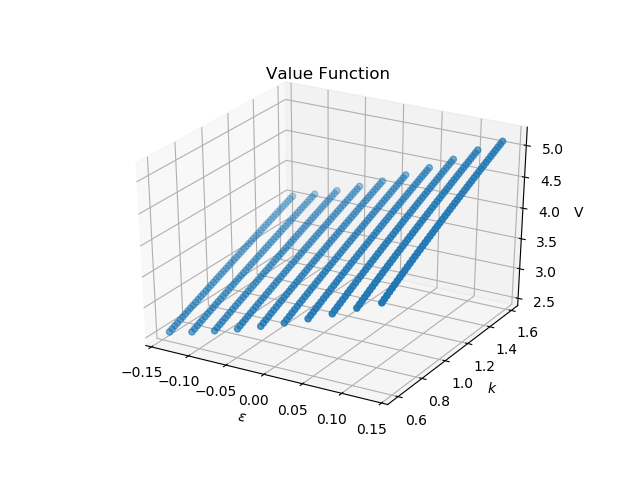

In [11]:
V, V_interp = solve_value_func_iter(w_ss, cf)

In [12]:
def extract_policy(V, V_interp, w, plot=True):

    poly_grid = np.zeros_like(V)
        
    for i in range(N_eps):
        for j in range(N_k):
            V_new, action_value = vf_update(i, j, V_interp, w, cf)
            
            if V_new == (1 - delta) * k_grid[j]:
                poly_grid[i, j] = 0
            
            else:
                poly_grid[i, j] = k_grid[np.argmax(action_value)]
        
    if plot:
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        EPS, K = np.meshgrid(eps_grid, k_grid)
        #surf1 = ax.plot_surface(EPS, K, poly_grid.T, cmap=cm.autumn)
        surf1 = ax.scatter(EPS, K, poly_grid.T, cmap=cm.autumn)
        #fig.colorbar(surf1, shrink=.5, aspect=5)
        #surf1 = ax.plot_wireframe(EPS, K, V.T)
        ax.set_xlabel(r'$\epsilon$')
        ax.set_ylabel(r'$k$')
        ax.set_zlabel(r"$k'$")
        ax.set_title("Capital Accumulation Policy Function")
        
    return poly_grid

<IPython.core.display.Javascript object>


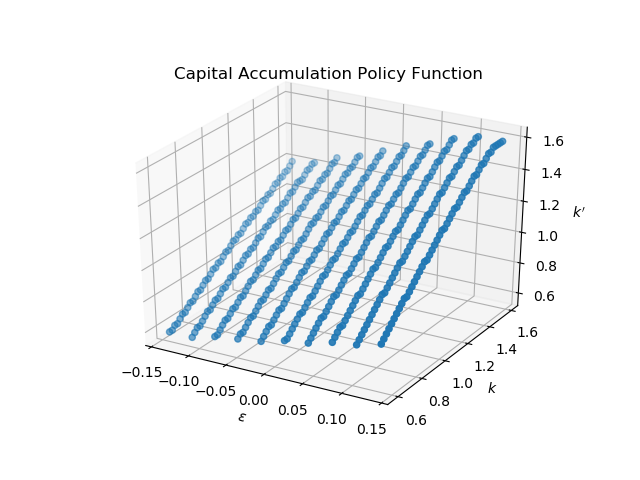

In [13]:
poly_grid = extract_policy(V, V_interp, w)

C:\Users\AKG\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:48: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


<IPython.core.display.Javascript object>


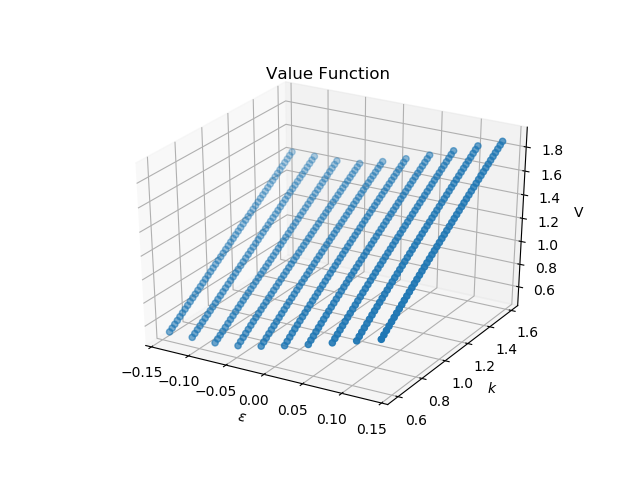

<IPython.core.display.Javascript object>


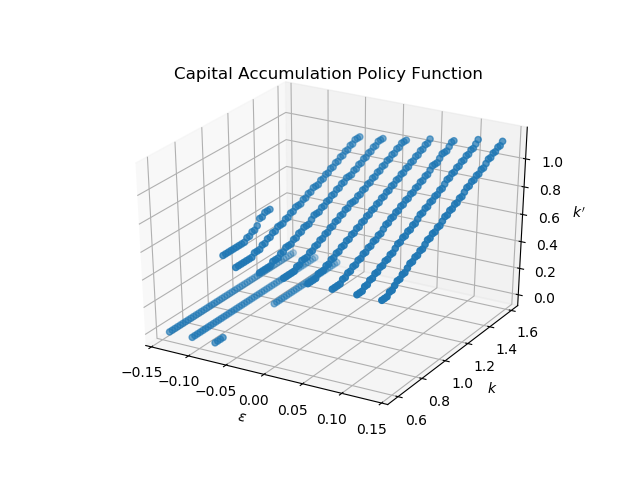

<IPython.core.display.Javascript object>


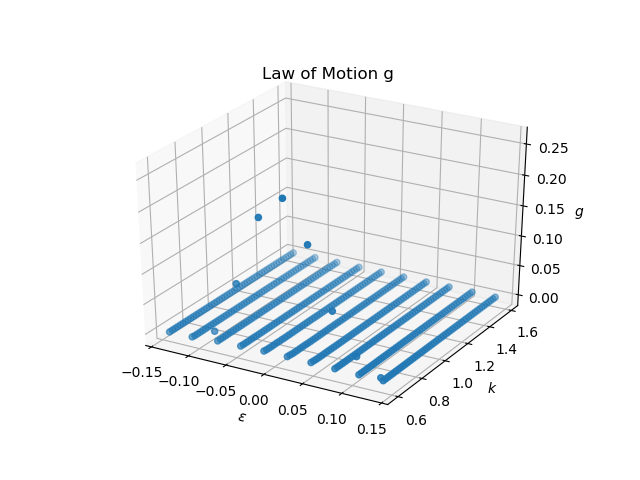

iteration  1
cf val:  0.01


<IPython.core.display.Javascript object>


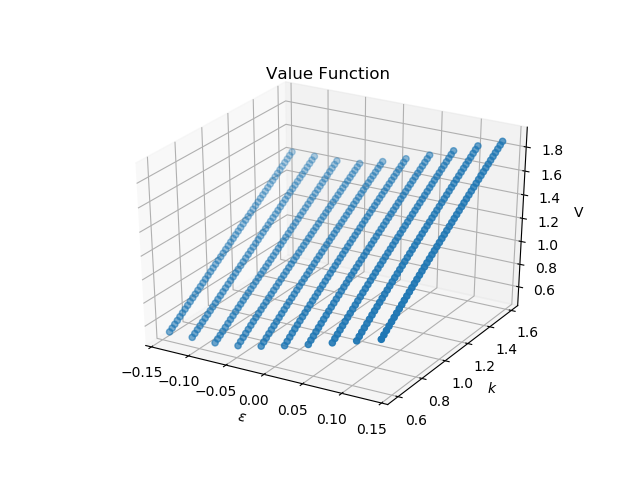

Fraction of exiting firms: 0.022483086312935815


iteration  2
cf val:  0.013


<IPython.core.display.Javascript object>


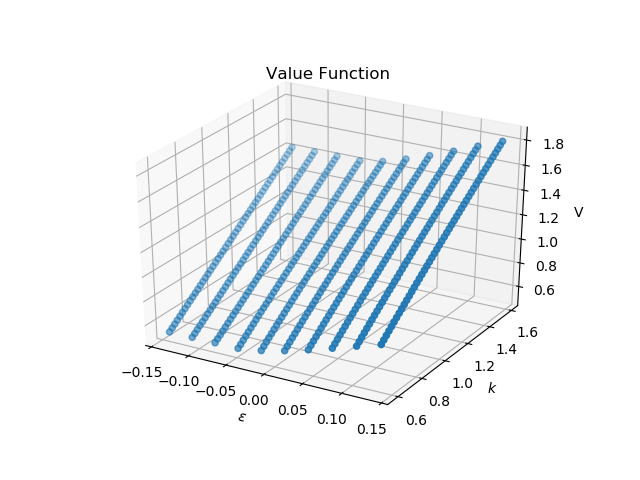

Fraction of exiting firms: 0.13252970530787647


iteration  3
cf val:  0.014


<IPython.core.display.Javascript object>


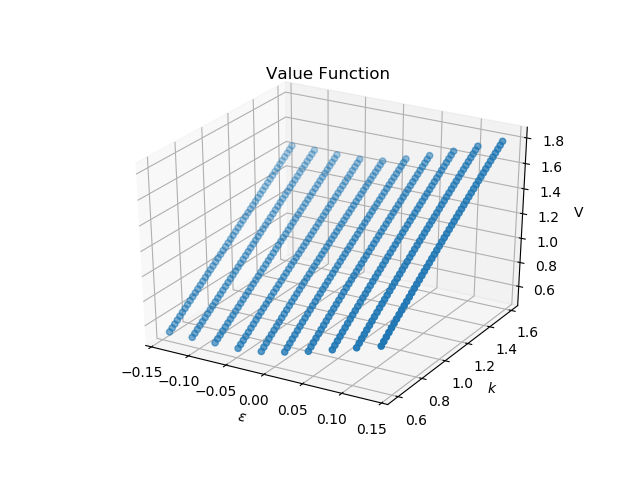

Fraction of exiting firms: 0.13406633900178572


iteration  4
cf val:  0.015


<IPython.core.display.Javascript object>


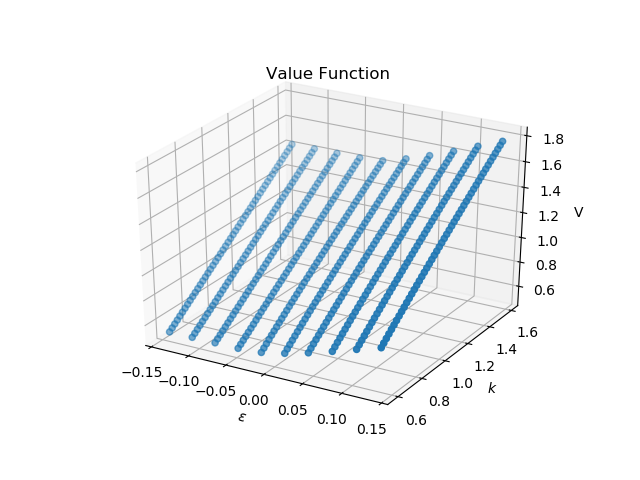

Fraction of exiting firms: 0.1360760449751801


iteration  5
cf val:  0.016


<IPython.core.display.Javascript object>


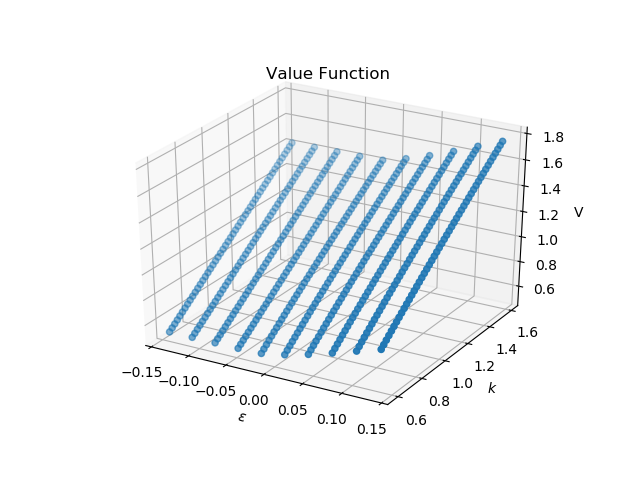

Fraction of exiting firms: 0.13906643107363217




0.01

In [14]:
# Firms continue
def firm_continue(eps, k, V_interp):
    V_val = V_interp(eps, k)
    if V_val == (1 - delta) * k:
        return False
    else:
        return True

firm_continue(0, 5, V_interp)

firm_continue(0.2, 1, V_interp)

def firm_continue_grid(V):
    V_new = np.zeros_like(V)
    for i in range(N_k):
        V_new[:, i] = ((1 - delta) * k_grid[i] != V[:, i]) 
    return V_new

firm_cont_grid = firm_continue_grid(V)



### Function $\hat{V}(\epsilon)$

def get_v_hat(eps, V_interp):
    
    eps_index = np.where(eps_grid == eps)[0][0]
    vals = []
    
    for k_index in range(N_k):
        val = - k_grid[k_index] + beta * np.dot(trans_eps_MC[eps_index, :], V_interp(eps_grid, k_grid[k_index]))
        vals.append(val)
    
    return max(vals)       

get_v_hat(eps_grid[4], V_interp)



ce = 0.02

### https://dilawarnotes.wordpress.com/2017/11/07/stationary-distribution-of-markov-chains-using-python/
def solveStationary( A ):
    n = A.shape[0]
    a = np.eye( n ) - A
    a = np.vstack( (a.T, np.ones( n )) )
    b = np.matrix( [0] * n + [ 1 ] ).T
    return np.linalg.lstsq( a, b )[0]

#### Stationary Distribution of $\epsilon$

stationary_dist_eps = np.array(solveStationary(trans_eps_MC))
stationary_dist_eps

np.sum(stationary_dist_eps)

### Solving for Market-Clearing Wage

def mark_wage_err(w, ce, cf):
    V_new, V_interp_new = solve_value_func_iter(w, cf, plot=False)
    
    V_hats = np.zeros_like(eps_grid)
    # iterate loop in parallel
    
    for i in range(len(eps_grid)):
        V_hats[i] = get_v_hat(eps_grid[i], V_interp_new)
    
    integral = np.dot(V_hats, stationary_dist_eps)
    err = ce - integral
    #print(err)
    return np.array(err)

def solve_mark_wage(w_guess, ce, cf):
    args = (ce, cf)
    result = opt.root(mark_wage_err, w_guess, args = args)
    return result.x[0]

w_star = solve_mark_wage(0.9, 0.02, 0.01)

w_star



## Q Stationary measure of firms and mass of entrants

V, V_interp = solve_value_func_iter(w_star, cf)

poly_grid = extract_policy(V, V_interp, w_star)

firm_cont_grid = firm_continue_grid(V)
#firm_cont_grid

### Step 1: Solving $g(\epsilon, k)$

g_init = np.random.uniform(low=0, high=1, size=(N_eps, N_k))
g_init = g_init / np.sum(g_init)
g = g_init.copy()
m_star = 1

np.sum(g)

@jit(nopython=True, parallel=True)
def update_g(g):
    g_new = np.zeros((N_eps, N_k))
    
    # iterate loop in parallel
    for k in range(N_eps):
        for l in range(N_k):
            C = (poly_grid == k_grid[l])
            
            summation = 0
            for i in range(N_eps):
                for j in range(N_k):
                    
                    sum_ij = trans_eps_MC[i,k] * C[i, j] * firm_cont_grid[i, j] * g[i, j] 
                    summation += sum_ij
                    
            summation += m_star * stationary_dist_eps[k][0]
            g_new[k, l] = summation
     
    return g_new

def solve_g(plot=True):
    threshold = 1e-8
    max_iterations = 1000
    diff = 1
    g = g_init.copy()
    
    while (diff > 1e-5):
        g_new = update_g(g) 
        #print('sum :', np.sum(g_new))
        diff = np.max(np.abs(g_new - g))
        #print(diff)
        g = g_new.copy()
    
    g_normalized = g_new / np.sum(g_new)
        
    if plot:
        
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        EPS, K = np.meshgrid(eps_grid, k_grid)
        surf1 = ax.scatter(EPS, K, g_normalized.T, cmap=cm.autumn)
        #fig.colorbar(surf1, shrink=.5, aspect=5)
        #surf1 = ax.plot_wireframe(EPS, K, g_normalized.T)
        ax.set_xlabel(r'$\epsilon$')
        ax.set_ylabel(r'$k$')
        ax.set_zlabel(r"$g$")
        ax.set_title("Law of Motion g")
        
    return g_normalized

g = solve_g()



### Step 2: Solving m*

def get_g_star(g, m):
    return g.copy() * m

def n(eps, k, w):
    n = (w / (mu * np.exp(eps) * k **theta)) ** (1/(mu - 1))
    return n

def agg_l_d(g_star, w_star):
    
    n_d = 0
    for i in range(N_eps):
        for j in range(N_k):
            n_d += n(eps_grid[i], k_grid[j], w_star) * g_star[i, j]
    return n_d

def m_error(m_guess, *args):
    
    g, w_star = args
    g_star = get_g_star(g, m_guess)
    n_d = agg_l_d(g_star, w_star)
    m_error = n_d - 0.6
    return m_error

def solve_m(m_guess, g, w_star):
    
    args = (g, w_star)
    result = opt.root(m_error, m_guess, args=args)
    return result.x[0]

m_guess = 0.5
m_star = solve_m(m_guess, g, w_star)
m_star



### Step 3: Solving value of a

def get_agg_Y():
    
    agg_Y = 0
    for i in range(N_eps):
        for j in range(N_k):
            agg_Y += ( np.exp(eps_grid[i]) * k_grid[i] ** theta * n(eps_grid[i], k_grid[j], w_star) ) * g[i, j]
    
    return agg_Y

get_agg_Y()

def get_agg_I():
    
    agg_I = 0
    for i in range(N_eps):
        for j in range(N_k):
            agg_I += ( poly_grid[i, j] - (1 - delta) * k_grid[j] ) * g[i, j]
            
    return agg_I

get_agg_I()

def get_agg_C():
    
    Y = get_agg_Y()
    I = get_agg_I()
    C = Y - I
    return C

get_agg_C()

def get_a():
    
    C = get_agg_C()
    a = C * w_star
    
    return a

get_a()



##  Calibration to parameters in the data, here it is the entry and exit costs

### (i) Calibrating entry cost: Calibrate to target annual exit rate of 10%.

def calibrate_cf():
    
    cf_range = [0.01, 0.013, 0.014, 0.015, 0.016]
    error = 1000
    cal_cf = 0
    iteration = 1
    for cf_val in cf_range:
        
        print("iteration ", iteration)
        print("cf val: ", cf_val)
        V, V_interp = solve_value_func_iter(w_star, cf_val, plot=True)
        
        frac_exit_sum = 0
        for i in range(N_k):
            V_i = V[:, i]
            exit_val = (1 - delta) * k_grid[i]
            exit_bool = (V_i == exit_val)
            
            frac_exit_i = exit_bool * g[:, i]
            frac_exit_sum += frac_exit_i.sum()
        
        print("Fraction of exiting firms:", frac_exit_sum)  
        print("\n")
        new_error = abs(frac_exit_sum - 0.1)
        #print(new_error)
            
        if new_error < error:
            error = new_error
            cal_cf = cf_val
                
        iteration += 1
                
    return cal_cf, error 

cal_cf, error = calibrate_cf()

cal_cf 



### (ii) Calibrating exit costs: Calibrate to target average size of new firms to be 40% of average size of all firms

def calibrate_ce():
    
    ce_range = [0.01, 0.05, 0.1, 0.2, 0.5]
    error = 1000
    cal_ce = 0
    iteration = 1
    for ce_val in ce_range:
        
        #print("iteration ", iteration)
        #print("ce val: ", ce_val)
        
        w_guess = 0.9
        w_star = solve_mark_wage(w_guess, ce, cal_cf)
        #print("w_star:", w_star)
        m_guess = 0.05
        m_star = solve_m(m_guess, g, w_star)
        #print("m_star :", m_star)
        
        new_error = abs(m_star - 0.4)
        if new_error < error:
            error = new_error
            cal_ce = ce_val
        
        iteration += 1
    
    return cal_ce, error

cal_ce, error = calibrate_ce()

cal_ce 

## References

   * Micro-level Heterogeneity and Transmission: [Reiter, Sveen and Weinke (2013)] (_Lumpy investment and the monetary transmission mechanism_), [Koby and Wolf (2019)] **(_Investment Stimulus: From Micro Elasticities to Macro Counterfactuals_)**.
   
   * Financial heterogeneity and  the business cycle dynamics of aggregate investment: [Khan, Senga and Thomas (2016)] **(_Default Risk and Aggregate Fluctuations in an Economy with Production Heterogeneity_)**.

   * Investment and Business Cycle: [Cooper, Haltiwanger (2006)] **(_Machine Replacement and the Business Cycle: Lumps and Bumps_)**. 
   
   * Heterogeneity and computation: [Krusell, Smith (1998)] **(_Income and wealth heterogeneity in the macroeconomy_)**.

   * Khan, A. and Thomas, J. K. (2008), Idiosyncratic Shocks and the Role of Nonconvexities in Plant and Aggregate Investment Dynamics. Econometrica, 76: 395-436.
   
   * Winberry, T. (2018), A method for solving and estimating heterogeneous agent macro models. Quantitative Economics, 9: 1123-1151.